## Pràctica 1: Resolem un problema de classificacio

#### Autores: Adrián González (1636620) y Carlos ()

### PLANIFICACIÓN DE LA PRÁCTICA

1. **Importar bibliotecas y cargar datos**
   - Importar las bibliotecas necesarias (pandas, sklearn, etc.).
   - Cargar los datos del Titanic.

2. **Análisis Exploratorio de Datos (EDA)**
   - Inspeccionar los atributos y sus tipos.
   - Evaluar el atributo objetivo y su distribución.
   - Identificar y tratar los valores faltantes.
   - Calcular correlaciones y visualizarlas.

3. **Preprocesamiento de Datos**
   - Normalizar los datos si es necesario.
   - Manejar valores faltantes (eliminar o imputar).
   - Codificar datos categóricos.
   - Realizar PCA si es apropiado.
   - Seleccionar características si es necesario.
   - Aplicar "PolynomialFeatures" si es útil.

4. **Selección de Métricas**
   - Elegir la métrica de evaluación (accuracy, f1-score, average precision).
   - Crear funciones para visualizar las curvas ROC y PR.
   - Utilizar "classification_report" para obtener métricas detalladas.

5. **Selección de Modelos con Validación Cruzada**
   - Definir los modelos a evaluar (por ejemplo, regresión logística, random forest, KNN, SVM).
   - Realizar validación cruzada para seleccionar el mejor modelo.
   - Realizar búsqueda de hiperparámetros para cada modelo.
   - Comparar los resultados en una tabla.
   - Ajustar la configuración de la validación cruzada y "k".
   - Explorar métodos de búsqueda de hiperparámetros.

6. **Análisis Final**
   - Interpretar las curvas ROC/PR y seleccionar la más relevante.
   - Evaluar las métricas detalladas y definir una métrica principal.
   - Considerar mejoras posibles para el modelo.


 ### 1. Importar bibliotecas y cargar datos 📚

In [6]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, precision_recall_curve, roc_curve, auc, classification_report
import matplotlib.pyplot as bplt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import time

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 2. Análisis Exploratorio de Datos (EDA) 🔎

**Variables Numéricas:**

    - Calcular estadísticas descriptivas: la media, la mediana, la desviación estándar, el mínimo y el máximo.
    - Visualizar histogramas y boxplots para entender la distribución de los datos.
    - Realizar un análisis de valores atípicos (outliers) para identificar observaciones inusuales.
    - Calcular correlaciones entre las variables numéricas utilizando matrices de correlación y mapas de calor.
    - Crear gráficos de dispersión para explorar relaciones entre pares de variables numéricas.

**Variables Categóricas:**

    - Calcular la frecuencia de cada categoría para comprender la distribución de las variables categóricas.
    - Crear gráficos de barras o gráficos de pastel para visualizar la distribución de categorías.
    - Evaluar la relación entre variables categóricas
    - Realizar análisis de variables categóricas respecto a la variable objetivo.
    - Identificar y manejar categorías raras o poco frecuentes si es necesario.

In [8]:
print("Numero de columnas en el train (atributos): ",df_train.shape[1])
print("---------------------------------------")
print("Numero de filas en el train (muestras): ",df_train.shape[0])

Numero de columnas en el train (atributos):  12
---------------------------------------
Numero de filas en el train (muestras):  891


In [9]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None



| Variable    | Tipo        | Descripción                                         |
|------------ |------------ |--------------------------------------------------- |
| passengerId | int64         | Valor de identificación único de cada pasajero     |
| name        | object      | Nombre del pasajero                                |
| sex         | object      | Género (masculino o femenino)                      |
| age         | float64     | Edad de la persona (niños menores de 12 meses representados en fracción de año) |
| pclass       | int64      | Clase del ticket (1 = 1ra, 2 = 2da, 3 = 3ra)                        |
| embarked    | object      | Puerto de embarque de las personas                |
| ticket    | object     | Número de ticket (NA para la tripulación)         |
| fare        | float64     | Precio del ticket (NA para la tripulación, músicos, empleados y otros) |
| sibsp       | int64 | Número de hermanos/familiares                  |
| cabin       | object      | Tipo de cabina ocupada por el pasajero            |
| parch       | int64 | Número de padres e hijos a bordo               |
| survived    | int64 | Sobrevive (0 = No, 1 = Si) al hundimiento      |

- Variables numéricas: Age, Fare, SibSp, Parch 

- Variables categóricas: Survived (Binario), Sex (Binario), Embarked, Pclass (Ternario), Name, PassengerId, Ticket, Cabin

In [10]:
def has_nans(df):
  return df.isna().sum().sum()>0


print ("¿Tenemos Nans?")
print (has_nans(df_train))
if(has_nans(df_train)):
    print ("Si es así, ¿cuantos?")
    print(pd.isnull(df_train).sum())

¿Tenemos Nans?
True
Si es así, ¿cuantos?
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [11]:
df_train.describe(include="all")

PassengerId  Survived  Pclass                     Name   Sex     Age  \
count       891.000   891.000 891.000                      891   891 714.000   
unique          NaN       NaN     NaN                      891     2     NaN   
top             NaN       NaN     NaN  Braund, Mr. Owen Harris  male     NaN   
freq            NaN       NaN     NaN                        1   577     NaN   
mean        446.000     0.384   2.309                      NaN   NaN  29.699   
std         257.354     0.487   0.836                      NaN   NaN  14.526   
min           1.000     0.000   1.000                      NaN   NaN   0.420   
25%         223.500     0.000   2.000                      NaN   NaN  20.125   
50%         446.000     0.000   3.000                      NaN   NaN  28.000   
75%         668.500     1.000   3.000                      NaN   NaN  38.000   
max         891.000     1.000   3.000                      NaN   NaN  80.000   

         SibSp   Parch  Ticket    Fare    Cabin Embarked  
count  891.000 891.000     891 891.000      204      889  
unique     NaN     NaN     681     NaN      147        3  
top        NaN     NaN  347082     NaN  B96 B98        S  
freq       NaN     NaN       7     NaN        4      644  
mean     0.523   0.382     NaN  32.204      NaN      NaN  
std      1.103   0.806     NaN  49.693      NaN      NaN  
min      0.000   0.000     NaN   0.000      NaN      NaN  
25%      0.000   0.000     NaN   7.910      NaN      NaN  
50%      0.000   0.000     NaN  14.454      NaN      NaN  
75%      1.000   0.000     NaN  31.000      NaN      NaN  
max      8.000   6.000     NaN 512.329      NaN      NaN

Análisis de datos a simple vista:

- El total de pasageros es 891
- Así de primeras PassengerId y Ticket no creemos que vayan a ser muy relevantes al ser identificadores únicos, Fare igual (este último por que pclass es equivalente)

Deberemos tratar algunos NaNs:

- Existen columnas con muchos Nans: Age y Cabin 
- Embarked tiene dos NaNs

Cabin es poco relevante y tiene muchos NaNs

In [12]:
df_train = df_train.drop(['PassengerId', 'Ticket', 'Fare', 'Cabin'], axis=1)
df_test = df_test.drop(['PassengerId', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [13]:
df_train.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Embarked      3
dtype: int64

In [14]:
# Resumen estadístico de las variables categóricas
df_train.describe(include='O')

Name   Sex Embarked
count                       891   891      889
unique                      891     2        3
top     Braund, Mr. Owen Harris  male        S
freq                          1   577      644

0    549
1    342
Name: Survived, dtype: int64


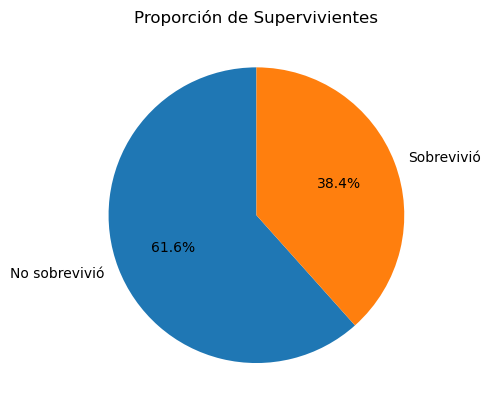

In [15]:
# Contar el número de pasajeros que sobrevivieron y que no sobrevivieron
survival_counts = df_train['Survived'].value_counts()
# Visualizar la proporción de sobrevivientes
print(survival_counts)
bplt.pie(survival_counts, labels=['No sobrevivió', 'Sobrevivió'], autopct='%1.1f%%', startangle=90)
bplt.title('Proporción de Supervivientes')
bplt.show()

Las etiquetas no están balanceadas, de hecho están bastante desbalanceadas. Esto se puede solucionar haciendo (up or down) sampling o stratified k-fold cross validation. 

La principal ventaja de la validación cruzada es que TODAS las observaciones se utilizan tanto en el conjunto de entrenamiento como en el de prueba. Además, CADA observación se utiliza una sola vez durante la validación. Cosa que probablemente no pase en el muestreo. En términos de muestreo, algunas observaciones pueden no utilizarse nunca en la parte de validación y ALGUNAS pueden utilizarse VARIAS veces, lo que provoca solapamientos. 

% mujeres supervivientes: 74.20382165605095
% hombres supervivientes: 18.890814558058924


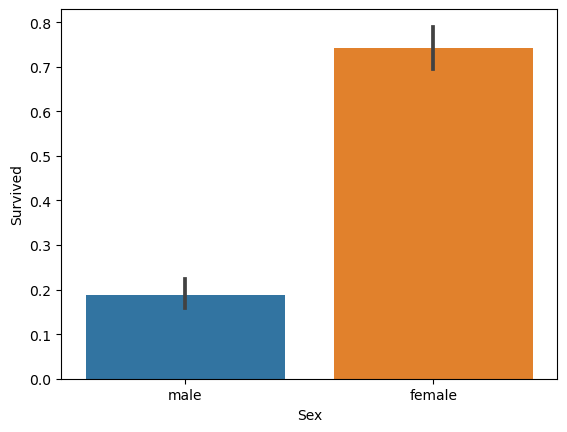

In [16]:
sns.barplot(x="Sex", y="Survived", data=df_train)

print("% mujeres supervivientes:", df_train["Survived"][df_train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("% hombres supervivientes:", df_train["Survived"][df_train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

Las mujeres son más propensas a sobrevivir.

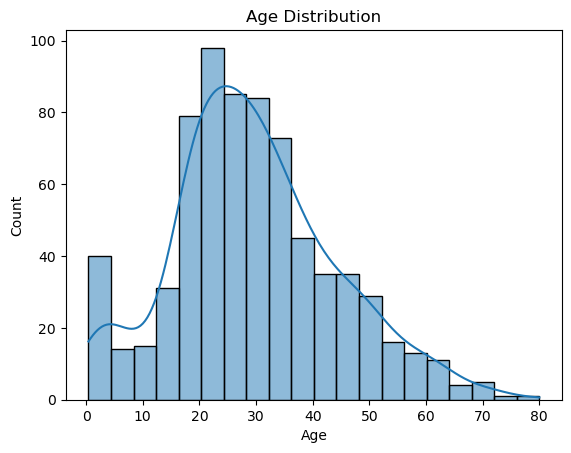

In [17]:
sns.histplot(data=df_train, x='Age', kde=True)
bplt.title('Age Distribution')
bplt.xlabel('Age')
bplt.ylabel('Count')
bplt.show()

Los jóvenes son más propensos a sobrevivir.

In [18]:
fig = px.histogram(df_train, x='Age', color='Survived', title='Survival by Age',
                   marginal='box', barmode='group', color_discrete_sequence=['#ff7f0e', '#3498db'],
                   )

fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
)

fig.show()

Sobreviven más personas jóvenes, pero tampoco hay una gran diferencia. De hecho, sobreviven más jóvenes por que en el barco habían más jóvenes.

% de Pclass = 1 supervivientes: 62.96296296296296
% de Pclass = 2 supervivientes: 47.28260869565217
% de Pclass = 3 supervivientes: 24.236252545824847


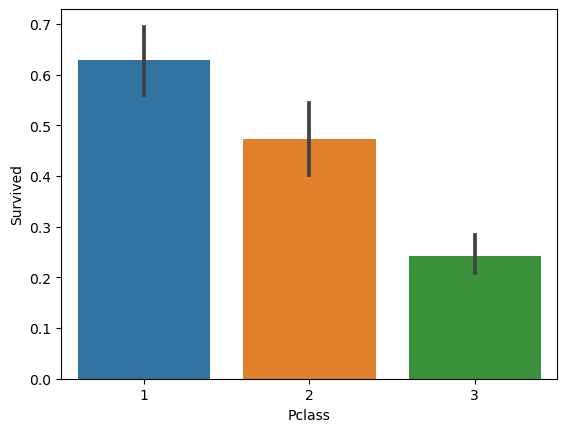

In [19]:
sns.barplot(x="Pclass", y="Survived", data=df_train)

print("% de Pclass = 1 supervivientes:", df_train["Survived"][df_train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("% de Pclass = 2 supervivientes:", df_train["Survived"][df_train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("% de Pclass = 3 supervivientes:", df_train["Survived"][df_train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

Pclass: Sobreviven más los de 1º y 2º clase que los de 3º (lógico)

% de Embarked = S supervivientes: 33.69565217391305
% de Embarked = C supervivientes: 55.35714285714286
% de Embarked = Q supervivientes: 38.961038961038966


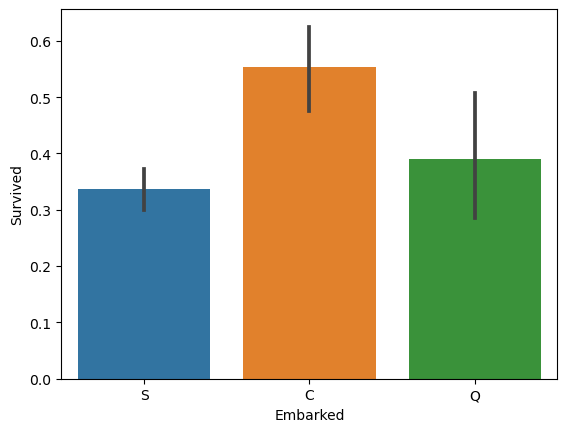

In [20]:
sns.barplot(x="Embarked", y="Survived", data=df_train)

print("% de Embarked = S supervivientes:", df_train["Survived"][df_train["Embarked"] == 'S'].value_counts(normalize = True)[1]*100)

print("% de Embarked = C supervivientes:", df_train["Survived"][df_train["Embarked"] == 'C'].value_counts(normalize = True)[1]*100)

print("% de Embarked = Q supervivientes:", df_train["Survived"][df_train["Embarked"] == 'Q'].value_counts(normalize = True)[1]*100)

Embarked: Sobreviven más los que embarcaron desde el puerto C.

### 3. Preprocesamiento de Datos ⚒️

Antes de empezar con el preprocesamiento cabe recalcar que habíamos decidido no aplicar ningún tipo de normalización MinMax / Standard / RobustScalers puesto que los rangos no son demasiado diferentes (excepto age, pero no creíamos que normalizar marcase tanto la diferencia) y solo se vería una pequeña diferencia usando SVM que es más sensible a escala. 

Pues resulta que hemos comprobado que es muy sensible a escala y si no escalamos age obtenemos un 0.40 de f1-score, mientras que si escalamos obtenemos un 0.77, por lo que se normalizará al final del apartado.


Fusionamos SibSp y Parch en FamSize

In [21]:
df_train['FamSize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamSize'] = df_test['SibSp'] + df_test['Parch'] + 1

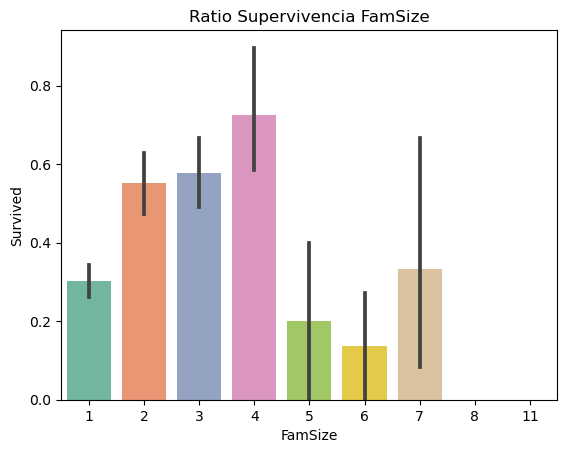

In [22]:
sns.barplot(data=df_train, x='FamSize', y='Survived', palette='Set2')
bplt.title('Ratio Supervivencia FamSize')
bplt.show()

FamSize: Las familias más pequeñas (1 a 4) eran más propensas a sobrevivir

In [23]:
df_train["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [24]:
name = df_train["Name"]
df_train["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]
name = df_test["Name"]
df_test["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]

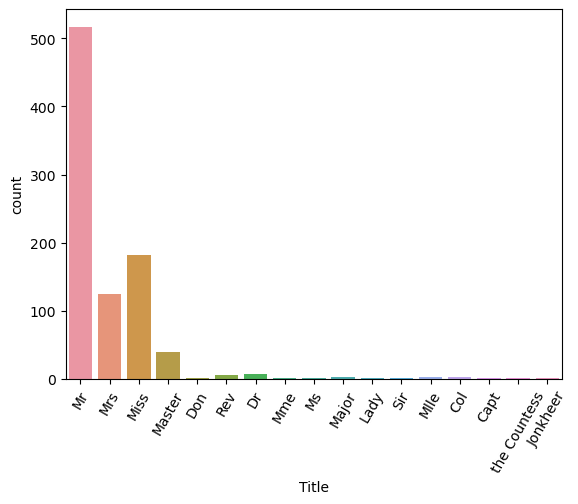

In [25]:
sns.countplot(x="Title", data = df_train)
bplt.xticks(rotation = 60)
bplt.show()

Algunos métodos de aprendizaje automático como las máquinas de soporte vectorial (SVM) no toleran valores nulos en los datos (Los valores Nans pueden interferir con la definición del hiperplano óptimo). Además, si decidimos eliminar las filas que contienen Nans podemos perder información valiosa y reducir el tamaño del conjunto de datos. Por tanto se ha decidido tratar dichos Nans rellenándolos (excepto con Cabin que contenía demasiados Nans y vimos mejor eliminar la columna).

Por ejemplo, utilizamos los promedios de edad de df_train para llenar valores faltantes en las columnas de edad de df_train y df_test en función de las características "Pclass" "Sex" y "Title" de cada pasajero. 

In [26]:
grp = df_train.groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

def fill_age(x):
    return grp[(grp.Pclass==x.Pclass)&(grp.Sex==x.Sex)&(grp.Title==x.Title)]['Age'].values[0]

df_train['Age'] = df_train.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)

grp = df_test.groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
df_test['Age'] = df_test.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)

In [27]:
df_train.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex    Age  SibSp  Parch Embarked  FamSize Title  
0    male 22.000      1      0        S        2    Mr  
1  female 38.000      1      0        C        2   Mrs  
2  female 26.000      0      0        S        1  Miss  
3  female 35.000      1      0        S        2   Mrs  
4    male 35.000      0      0        S        1    Mr

In [28]:
titulos_principales = ["Mr", "Mrs", "Miss", "Master"]

df_train["Title"] = df_train["Title"].apply(lambda x: x if x in titulos_principales else "Otro")
df_test["Title"] = df_test["Title"].apply(lambda x: x if x in titulos_principales else "Otro")
df_train.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex    Age  SibSp  Parch Embarked  FamSize Title  
0    male 22.000      1      0        S        2    Mr  
1  female 38.000      1      0        C        2   Mrs  
2  female 26.000      0      0        S        1  Miss  
3  female 35.000      1      0        S        2   Mrs  
4    male 35.000      0      0        S        1    Mr

In [29]:
df_train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Otro'], dtype=object)

**One-Hot encoding:** La estrategia básica consiste en convertir cada valor de categoría en una nueva columna y asignarle un valor 1 O 0 (Verdadero/Falso). Esto tiene la ventaja de no ponderar un valor indebidamente. Podemos utilizar .get_dummies() de pandas. Si todas las variables categóricas estuvieran en una sola columna, se asumiría que existe una relación lineal entre ellas. En nuestro caso las variables Title, Sex y Embarked son nominales por lo que tiene todo el sentido aplicar One-Hot encoding.  

In [30]:
df_train = pd.get_dummies(df_train, columns=["Title"])
df_test = pd.get_dummies(df_test, columns=["Title"])
df_train.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex    Age  SibSp  Parch Embarked  FamSize  Title_Master  Title_Miss  \
0    male 22.000      1      0        S        2             0           0   
1  female 38.000      1      0        C        2             0           0   
2  female 26.000      0      0        S        1             0           1   
3  female 35.000      1      0        S        2             0           0   
4    male 35.000      0      0        S        1             0           0   

   Title_Mr  Title_Mrs  Title_Otro  
0         1          0           0  
1         0          1           0  
2         0          0           0  
3         0          1           0  
4         1          0           0

In [31]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputed_column = imputer.fit_transform(df_train['Embarked'].values.reshape(-1, 1))

imputed_column = imputed_column.flatten()

df_train['Embarked'] = imputed_column

imputed_column_test = imputer.fit_transform(df_test['Embarked'].values.reshape(-1, 1))

imputed_column_test = imputed_column_test.flatten()

df_test['Embarked'] = imputed_column_test

Relleno los NaNs de Embarked basándome en la moda (valor que + se repite).

In [32]:
df_train = pd.get_dummies(df_train, columns=['Sex', 'Embarked'])
df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked'])
encoded = list(df_train.columns)
print("{} columnas despues de hacer one-hot encoding.".format(len(encoded)))
df_train.head()

17 columnas despues de hacer one-hot encoding.


Survived  Pclass                                               Name    Age  \
0         0       3                            Braund, Mr. Owen Harris 22.000   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th... 38.000   
2         1       3                             Heikkinen, Miss. Laina 26.000   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel) 35.000   
4         0       3                           Allen, Mr. William Henry 35.000   

   SibSp  Parch  FamSize  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0      1      0        2             0           0         1          0   
1      1      0        2             0           0         0          1   
2      0      0        1             0           1         0          0   
3      1      0        2             0           0         0          1   
4      0      0        1             0           0         1          0   

   Title_Otro  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0           0         1           0           0           1  
1           0           1         0           1           0           0  
2           0           1         0           0           0           1  
3           0           1         0           0           0           1  
4           0           0         1           0           0           1

<AxesSubplot:>

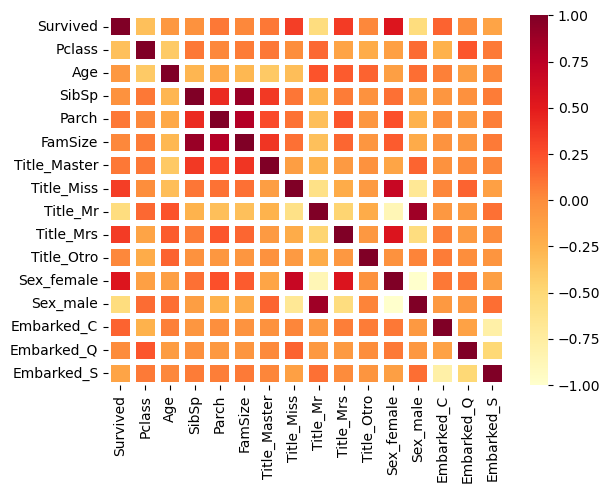

In [33]:
# Calcular la matriz de correlación
sns.heatmap(df_train.corr(),cmap="YlOrRd", edgecolor = "#1c1c1c", linewidth = 3)

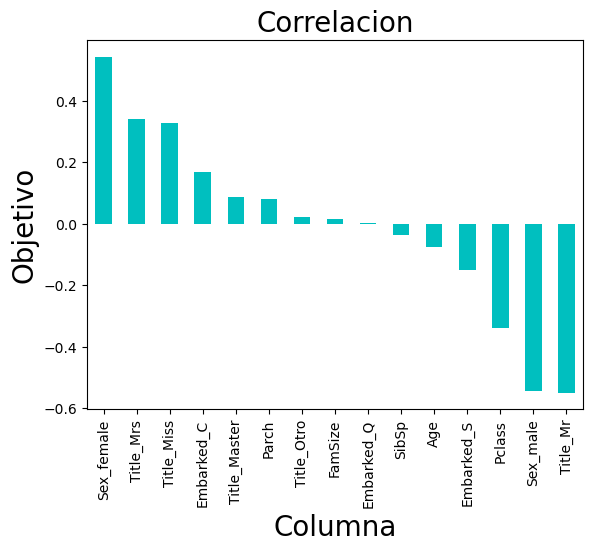

In [34]:
df_train.corr()['Survived'].sort_values(ascending = False).drop(['Survived']).plot(kind = 'bar', color = 'c')

bplt.xlabel('Columna', fontsize = 20)

bplt.ylabel('Objetivo', fontsize = 20)

bplt.title('Correlacion', fontsize = 20)

bplt.show()

En este momento nos damos cuenta de que añadir la columna FamSize quizá no era tan buena idea, pero se nos ocurrió un nuevo atributo a partir de este que quizás tuviera algo más de relación con la variable objetivo:

In [35]:
df_train['HasFamily'] = (df_train['FamSize'] > 1).astype(int)
df_test['HasFamily'] = (df_test['FamSize'] > 1).astype(int)

In [36]:
df_train = df_train.drop(['FamSize'], axis=1)
df_test = df_test.drop(['FamSize'], axis=1)

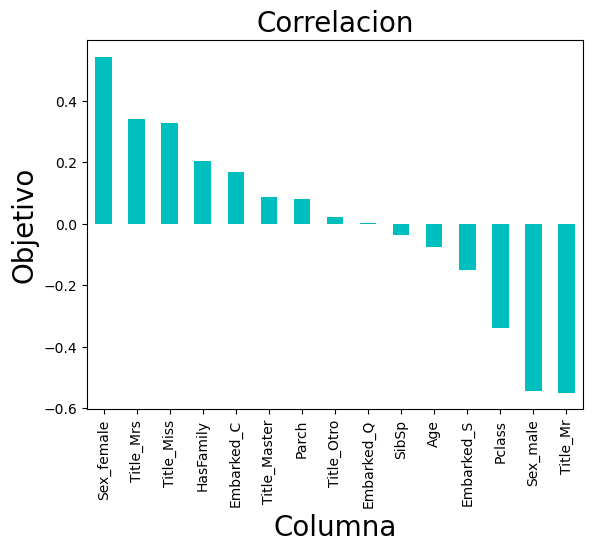

In [37]:
df_train.corr()['Survived'].sort_values(ascending = False).drop(['Survived']).plot(kind = 'bar', color = 'c')

bplt.xlabel('Columna', fontsize = 20)

bplt.ylabel('Objetivo', fontsize = 20)

bplt.title('Correlacion', fontsize = 20)

bplt.show()

Mucho mejor ahora.

Hemos usado la correlación entre las características numéricas y la variable objetivo (sobrevivencia en el caso del Titanic) para seleccionar características numéricas relevantes. 

También hemos seguido el criterio de Valores nulos (Si una columna contiene una gran cantidad de valores nulos (NaN) carece de información sustancial) y de Identificadores únicos (Si una columna es un identificador único para cada fila generalmente no aporta información predictiva se elimina para evitar el sobreajuste del modelo). 

PCA es útil cuando se tiene un conjunto de datos con muchas características numéricas y se busca reducir la dimensionalidad mientras se mantiene la mayor cantidad de información posible. En nuestro caso lo descartamos por que solo tenemos 4 (Variables numéricas: Age, Fare, SibSp, Parch).

Ventajas y desventajas: 

- PCA permite reducir la dimensionalidad al resumir la información en un conjunto más pequeño de componentes principales.
- Si hubiera correlación fuerte entre las características originales, PCA podría ayudar a reducir dicha multicolinealidad.
- Aplicar PCA afecta a la interpretabilidad y dificultar la comprensión de la importancia de cada característica en el contexto del problema.
- Con pocas características numéricas no tiene sentido (nuestro caso).

Igualmente, para nuestro dataset, las transformaciones polinómicas (PolynomialFeatures) no son necesarias. En su lugar, nos hemos enfocado en técnicas de preprocesamiento y selección de características que se ajusten a las características específicas de este conjunto de datos.  Tiene sentido en modelos lineales para capturar relaciones no lineales entre características. No es comúnmente necesario para árboles de decisión o Random Forests, y en SVM, se usa en núcleos polinómicos. 

In [38]:
df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

In [39]:
scaler = StandardScaler()

# Ajusta y transforma la columna 'Age' en el conjunto de entrenamiento
df_train['Age'] = scaler.fit_transform(df_train['Age'].values.reshape(-1, 1))

# Transforma la columna 'Age' en el conjunto de prueba utilizando los mismos parámetros
df_test['Age'] = scaler.transform(df_test['Age'].values.reshape(-1, 1))

## 4. Metric and model selection

Para nuestro problema escogeremos **f1-score** ya que  tiene en cuenta tanto la precisión como el recall, lo que convierte esta métrica en la más robusta para conjuntos de datos desequilibrados y escenarios en los que la identificación correcta de instancias positivas es crucial. 

La Curva ROC no es la métrica más adecuada en conjuntos de datos altamente desequilibrados, ya que puede dar una impresión optimista del rendimiento del modelo. Dado que estamos interesados en la identificar correctamente los pasajeros que sobrevivieron en un dataset desequilibrado, la curva PR es más apropiada. Evalúa la precisión y el recall directamente (como el f1-score) lo que es esencial cuando la clase positiva (sobrevivientes) es menos común.

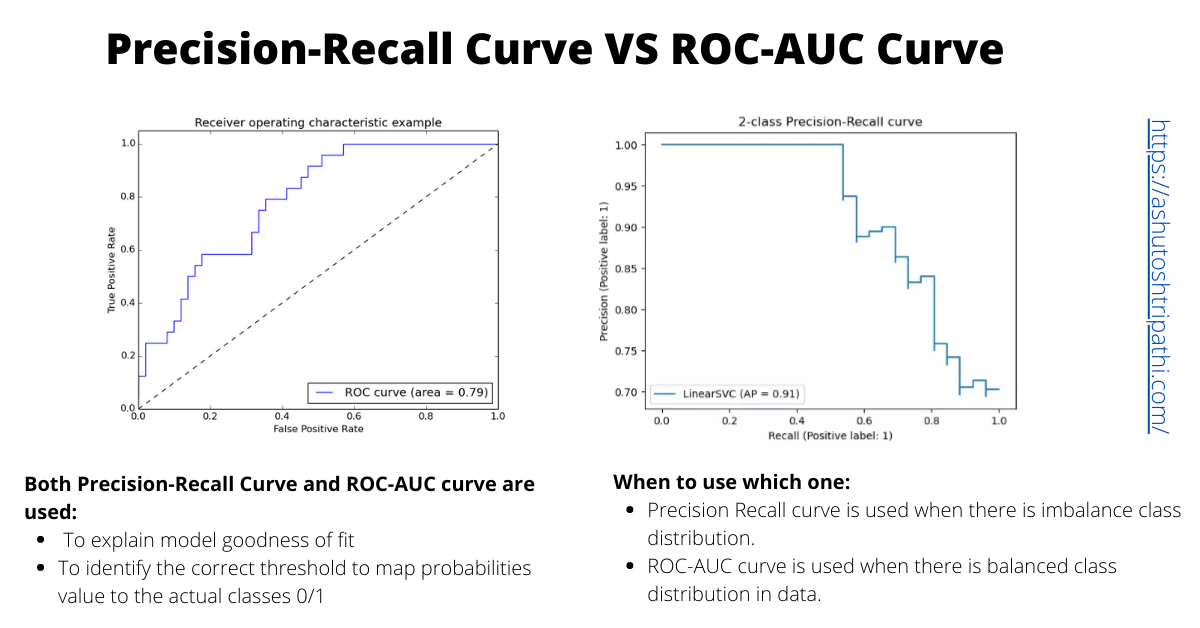

In [40]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

In [41]:
def plot_f1_scores(classifiers, X_train, y_train, cv=5):
    log_cols = ["Classifier", "F1-Score (Train)", "PR AUC", "ROC AUC"]
    log_list = []

    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    pr_recall_curves = {}
    roc_curves = {}
    
    for clf_name, clf in classifiers:
        f1_scores_train = []
        pr_auc_scores = []
        roc_auc_scores = []

        for train_index, val_index in stratified_kfold.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            clf.fit(X_train_fold, y_train_fold)
            y_pred_train = clf.predict(X_val_fold)

            f1_train = f1_score(y_val_fold, y_pred_train)
            f1_scores_train.append(f1_train)

            if hasattr(clf, "predict_proba"):
                y_scores = clf.predict_proba(X_val_fold)[:, 1]
            else:
                y_scores = clf.decision_function(X_val_fold)

            precision, recall, _ = precision_recall_curve(y_val_fold, y_scores)
            pr_auc = auc(recall, precision)
            pr_auc_scores.append(pr_auc)

            fpr, tpr, _ = roc_curve(y_val_fold, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_auc_scores.append(roc_auc)

        mean_f1_train = np.mean(f1_scores_train)
        mean_pr_auc = np.mean(pr_auc_scores)
        mean_roc_auc = np.mean(roc_auc_scores)
        print(clf_name, 'f1_train:', mean_f1_train, 'PR:', mean_pr_auc, 'ROC:', mean_roc_auc)
        log_list.append([clf_name, mean_f1_train, mean_pr_auc, mean_roc_auc])

        precision, recall, _ = precision_recall_curve(y, clf.predict_proba(X)[:, 1])
        pr_curve = (recall, precision)
        roc_curve_data = roc_curve(y, clf.predict_proba(X)[:, 1])
        pr_recall_curves[clf_name] = pr_curve
        roc_curves[clf_name] = roc_curve_data

    log = pd.DataFrame(log_list, columns=log_cols)
    log = log.sort_values(by="F1-Score (Train)", ascending=False)

    fig, axs = bplt.subplots(3, 1, figsize=(10, 16))

    axs[0].barh(log['Classifier'], log['F1-Score (Train)'], color='lightgreen', label='Train', alpha=0.5)
    axs[0].set_xlim(0.7, 0.78)
    axs[0].set_xlabel('F1-Score')
    axs[0].set_title('F1-Score Comparison (Train vs Test)')

    for i, clf_name in enumerate(log['Classifier']):
        axs[1].plot(pr_recall_curves[clf_name][0], pr_recall_curves[clf_name][1], label=f'{clf_name} (AUC = {log["PR AUC"].iloc[i]:.2f})')
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc='best')

        axs[2].plot(roc_curves[clf_name][0], roc_curves[clf_name][1], label=f'{clf_name} (AUC = {log["ROC AUC"].iloc[i]:.2f})')
        axs[2].set_xlabel('False Positive Rate')
        axs[2].set_ylabel('True Positive Rate')
        axs[2].set_title('ROC Curve')
        axs[2].legend(loc='best')

    bplt.tight_layout()
    bplt.show()

Esta función aparte de graficar la diferencia de f1-scores entre clasificadores graficará las curvas PR y ROC y también devolverá diversas métricas con el siguiente formato:

model    mean_f1      mean_pr_auc     mean_roc_auc  

**ELECCIÓN DE CLASIFICADORES**

Regresión Logística:

Ventajas:
- Fácil de entender y explicar.
- Eficiente en términos computacionales.
- Puede proporcionar probabilidades de supervivencia.

Puede ser una buena opción para una primera evaluación debido a su simplicidad y capacidad para proporcionar probabilidades.

KNN:

Ventajas:
- Puede capturar relaciones no lineales en los datos.
- Los grupos de pasajeros con características similares podrían tener probabilidades de supervivencia similares.

Puede ser útil si la supervivencia depende de la proximidad en el espacio de características.

Gaussian Naive Bayes:

Ventajas:
- Simple y rápido de entrenar.
- Funciona bien en datos con atributos categóricos y continuos.

Es útil si el conjunto de datos contiene una mezcla de características categóricas y numéricas, como la clase de pasajeros y la edad.

Árbol de Decisión (Decision Tree):

Ventajas:
- Puede ser útil para visualizar relaciones entre características y decisiones de supervivencia.

Se puede interpretar fácilmente las decisiones de supervivencia en función de las características.

Random Forest:

Ventajas:
- Combina múltiples árboles para reducir el overfitting.
- Capaz de manejar datos categóricos y numéricos.

Modelo más robusto que los árboles individuales y esperamos obtener un buen rendimiento.

AdaBoost:

Ventajas:
- Mejora la precisión de modelos débiles mediante ponderación.
- Puede adaptarse a diferentes tipos de clasificadores base.

Puede ser útil por que creemos que algunos atributos son más importantes que otros para determinar la supervivencia.

Gradient Boosting:

Ventajas:
- Combina múltiples modelos débiles para mejorar el rendimiento.
- Robusto frente al overfitting.

Es un modelo preciso y es robusto frente al overfitting.

Máquinas de Vectores de Soporte (SVM):

Ventajas:
- Buen rendimiento en conjuntos de datos con separación lineal o no lineal.
- Puede manejar datos numéricos y categóricos.

Puede ser útil si la supervivencia está fuertemente influenciada por un subconjunto de características.

Logistic Regression f1_train: 0.7775257316904366 PR: 0.8553629454858849 ROC: 0.8719397807351538
KNN f1_train: 0.7509338578088578 PR: 0.8307576999125654 ROC: 0.8506810165049448
Gaussian Naive Bayes f1_train: 0.746562933915644 PR: 0.7667847178780312 ROC: 0.8393400795064372
Decision Tree f1_train: 0.7181590195612926 PR: 0.7512555100625887 ROC: 0.7573312727926867
Random Forest f1_train: 0.7452754873650396 PR: 0.8008780180413748 ROC: 0.8345801150717385
AdaBoost f1_train: 0.7531331572299149 PR: 0.8404962463836616 ROC: 0.8633649364666633
Gradient Boosting f1_train: 0.764340835256524 PR: 0.8396017614505782 ROC: 0.8686047729459118
SVM f1_train: 0.7710544722215628 PR: 0.8289937176846852 ROC: 0.8545676348648028


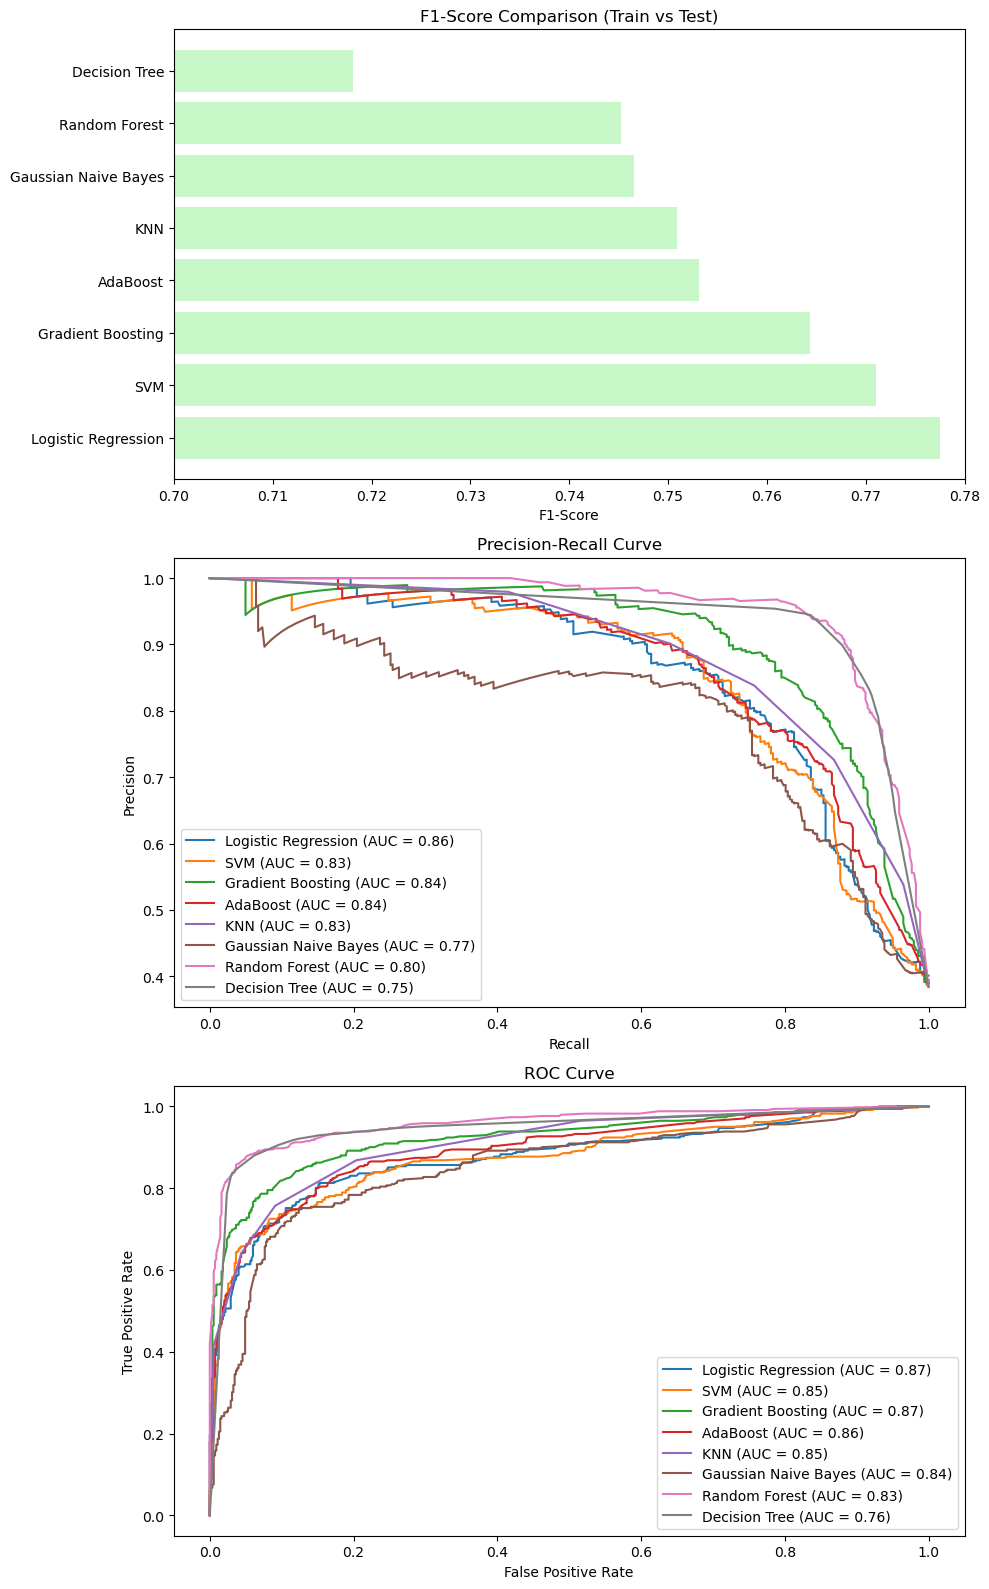

In [42]:
classifiers = [
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000)),
    ("KNN", KNeighborsClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("SVM", SVC(random_state=42, probability=True)),
]

plot_f1_scores(classifiers, X, y)

Hemos comprobado estos cambios en la F1-SCORE dependiendo de si normalizabamos age o no:

**age sin normalizar**
Logistic Regression 0.77464803384871
KNN 0.7397641349821582
Gaussian Naive Bayes 0.746562933915644
Decision Tree 0.7181343668056279
Random Forest 0.7414818255561106
AdaBoost 0.7531331572299149
Gradient Boosting 0.764340835256524
SVM 0.41024693697107495

**age normalizado**
Logistic Regression 0.7775257316904366
KNN 0.7509338578088578
Gaussian Naive Bayes 0.746562933915644
Decision Tree 0.7181590195612926
Random Forest 0.7452754873650396
AdaBoost 0.7531331572299149
Gradient Boosting 0.764340835256524
SVM 0.7710544722215628

En cuanto a la cross-validation, es mejor usar la validación cruzada **StratifiedKFold** en nuestro dataset debido a la necesidad de mantener una proporción equilibrada entre las clases de supervivencia durante la validación, teniendo en cuenta la distribución real de los datos y evitando sesgos en la estimación del rendimiento.

Teniendo en cuenta los hiperparametros por defecto el mejor modelo ha resultado ser el siguiente:
- Logistic Regression f1_train: 0.7775257316904366 PR: 0.8553629454858849 ROC: 0.8719397807351538

In [43]:
for clf_name, clf in classifiers:
    print(clf_name)
    clf.fit(X, y)
    y_train_pred = clf.predict(X)
    train_report = classification_report(y, y_train_pred)
    print("Classification Report:")
    print(train_report)


Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       549
           1       0.80      0.76      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

KNN
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       549
           1       0.85      0.77      0.81       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891

Gaussian Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       549
           1       0.74      0.75      0.75       342

    accuracy                           0.80       891
   macro avg  

Precisión (Precision): Proporción de predicciones positivas que son correctas. Es útil para evaluar cuántas de las personas etiquetadas como sobrevivientes realmente sobrevivieron o cuántas de las personas etiquetadas como no sobrevivientes realmente no sobrevivieron.

Recall (Recall): Evaluar cuántos de los verdaderos sobrevivientes se han detectado.

F1-Score (F1-score): Proporciona un equilibrio entre la precisión y el recall, especialmente útil en conjuntos de datos desequilibrados, como en el caso del Titanic.

Soporte (Support): Cantidad de ejemplos en cada clase.

In [44]:
import time

In [45]:
def grid_search(X, y, model, param_grid, cv=5, hue_feat=None):
    grid = GridSearchCV(model, param_grid, 
                        scoring=make_scorer(f1_score),
                        cv=cv, verbose=3, n_jobs=32)

    grid.fit(X, y)
    df_tmp = pd.DataFrame(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False))

    df_summary = pd.DataFrame()
    mn_ts_scores = []
    for i, row in df_tmp.iterrows():
        mn_ts_scores.append(row[1])
        df_tmp = pd.DataFrame(row[0], index=[0])
        df_summary = pd.concat([df_summary, df_tmp])
    df_summary['mean test score'] = mn_ts_scores
    df_summary = df_summary.reset_index(drop=True)
    print(df_summary.head())
    print(df_summary.columns)
    sns.pairplot(data=df_summary, hue=hue_feat)
    bplt.show()

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X)
    f1_test = f1_score(y, y_pred_test)

    print(f'F1-Score en el conjunto de prueba: {f1_test}')

    return df_summary.head(10)

Fitting 5 folds for each of 182 candidates, totalling 910 fits
   leaf_size  n_neighbors  weights  mean test score
0         27            7  uniform            0.751
1         29            7  uniform            0.751
2         23            7  uniform            0.751
3         25            7  uniform            0.751
4         17            7  uniform            0.751
Index(['leaf_size', 'n_neighbors', 'weights', 'mean test score'], dtype='object')


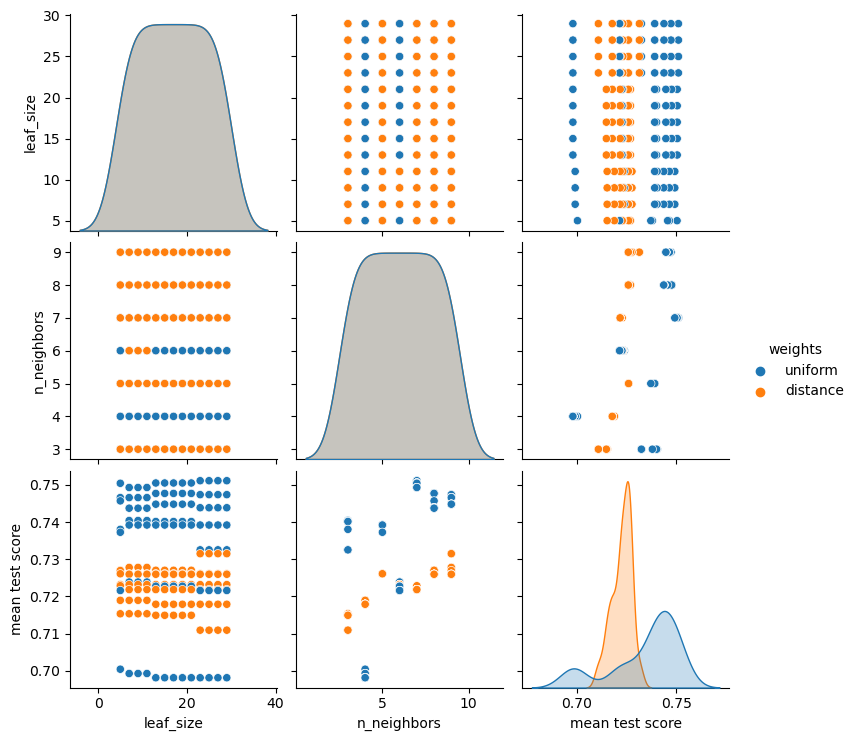

F1-Score en el conjunto de prueba: 0.7938461538461539
Tiempo de ejecución: 2.595423460006714 segundos


In [487]:
knc = KNeighborsClassifier()

param_knc = dict(n_neighbors=np.arange(3,10),weights=['uniform','distance'],# 
                 leaf_size=np.arange(5,30,2))

start_time = time.time()
df_knc = grid_search(X,y, knc, param_knc, hue_feat='weights')
df_knc

end_time = time.time()  
elapsed_time = end_time - start_time

print(f"Tiempo de ejecución: {elapsed_time} segundos")

Para **n_neighbors = 7** y para diversos valores de **leaf_size** (por ejemplo 17) el resultado de mean test score es el mismo por tanto nos quedaremos con estos valores de dichos hiperparámetros.

Fitting 5 folds for each of 63 candidates, totalling 315 fits


C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



   l1_ratio penalty  mean test score
0     0.500      l2            0.767
1     0.250      l2            0.767
2     0.700      l2            0.767
3     0.600      l2            0.767
4     0.550      l2            0.767
Index(['l1_ratio', 'penalty', 'mean test score'], dtype='object')


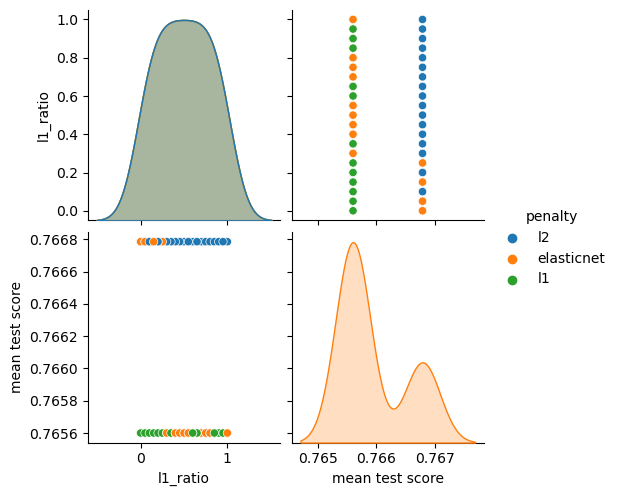

F1-Score en el conjunto de prueba: 0.7819548872180452
Tiempo de ejecución: 1.7657771110534668 segundos


In [491]:
log = LogisticRegression(solver='saga')

param_log = {'penalty':['l1', 'l2', 'elasticnet'],#None
             'l1_ratio':np.arange(0, 1.05, 0.05)}
start_time = time.time()
df_log = grid_search(X,y, log, param_log, hue_feat='penalty')
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

In [494]:
gb = GradientBoostingClassifier()

param_gb = {'loss':['logloss','deviance','exponential'],
            'learning_rate': np.arange(.01, .4, .05),
            'n_estimators':np.arange(50,410, 50),
            'max_depth':np.arange(1,12,2),
            }

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


1920 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not s

   learning_rate         loss  max_depth  n_estimators  mean test score
0          0.360     deviance          1           400            0.775
1          0.360     deviance          1           350            0.774
2          0.310     deviance          1           400            0.773
3          0.360     deviance          1           300            0.773
4          0.210  exponential          1           350            0.772
Index(['learning_rate', 'loss', 'max_depth', 'n_estimators',
       'mean test score'],
      dtype='object')


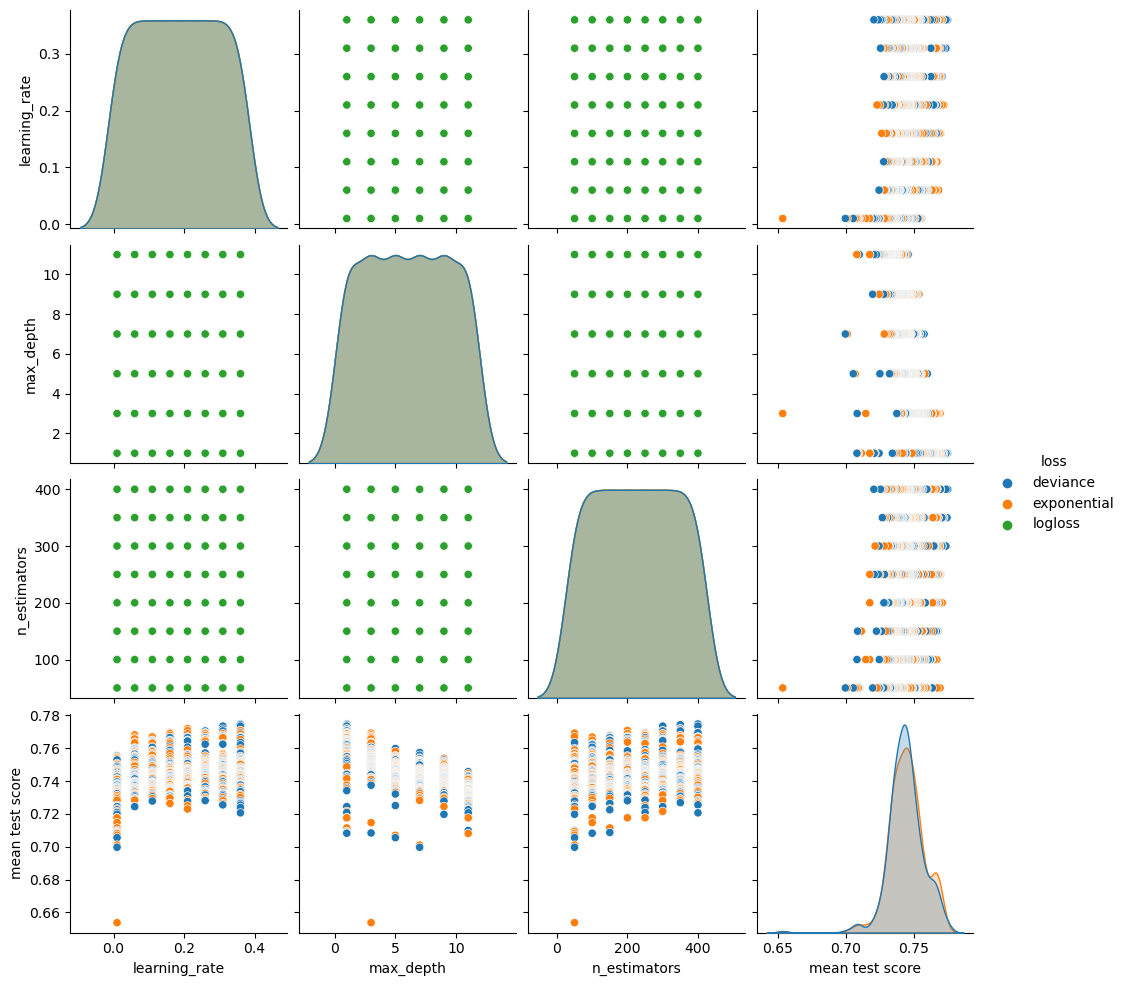

F1-Score en el conjunto de prueba: 0.8023774145616642
Tiempo de ejecución: 187.7025225162506 segundos


In [495]:
start_time = time.time()
df_gb = grid_search(X,y, gb, param_gb, hue_feat='loss')
df_gb
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

loss: deviance, el más apropiado para problemas de clasificación binaria
learning_rate: 0.360
n_estimators: 250
max_depth: 1

In [496]:
rf = RandomForestClassifier()

param_rf = dict(n_estimators=np.arange(50,410,50),max_depth=np.arange(3,16,2),
                 min_samples_leaf=np.arange(2,12,1), criterion=['gini','log_loss',  'entropy']
                 )


Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


2800 fits failed out of a total of 8400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File

  criterion  max_depth  min_samples_leaf  n_estimators  mean test score
0      gini          5                 3           150            0.771
1   entropy          5                 2           350            0.770
2   entropy          5                 4           300            0.770
3   entropy          5                 2           300            0.770
4   entropy          5                 5           250            0.769
Index(['criterion', 'max_depth', 'min_samples_leaf', 'n_estimators',
       'mean test score'],
      dtype='object')


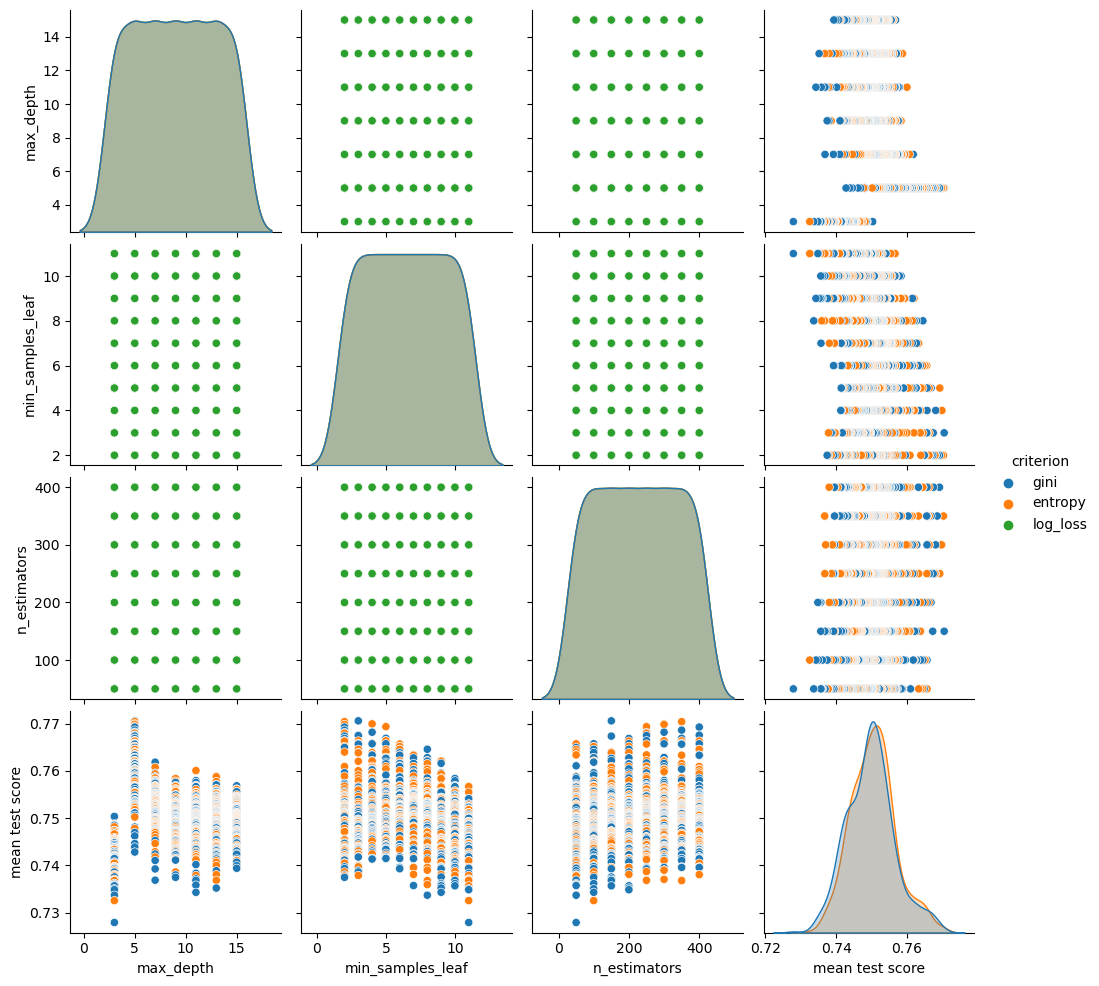

F1-Score en el conjunto de prueba: 0.7789799072642967
Tiempo de ejecución: 168.62861371040344 segundos


In [498]:
start_time = time.time()
df_rf = grid_search(X,y, rf, param_rf, hue_feat='criterion')
df_rf
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Criterion: "entropy"
Max Depth: 5
Min Samples Leaf: 4 o 5
N Estimators: 150 o 200

Fitting 5 folds for each of 126 candidates, totalling 630 fits
      C  gamma kernel  mean test score
0 1.000  scale    rbf            0.770
1 1.000   auto    rbf            0.770
2 1.000  0.100    rbf            0.770
3 0.100  0.400    rbf            0.770
4 0.100  0.200    rbf            0.766
Index(['C', 'gamma', 'kernel', 'mean test score'], dtype='object')


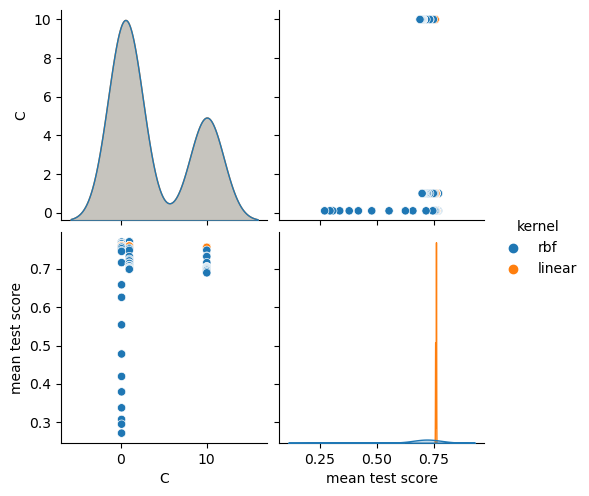

F1-Score en el conjunto de prueba: 0.773497688751926
Tiempo de ejecución: 2.678631544113159 segundos


In [500]:
svm_model = SVC()

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] + list(np.arange(0.1, 2.0, 0.1))
}

start_time = time.time()
df_svm_summary = grid_search(X,y, svm_model, param_svm, hue_feat='kernel')
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
   learning_rate  n_estimators  mean test score
0          1.000           170            0.769
1          1.000           190            0.768
2          1.000           180            0.768
3          1.000           160            0.768
4          1.000            90            0.766
Index(['learning_rate', 'n_estimators', 'mean test score'], dtype='object')


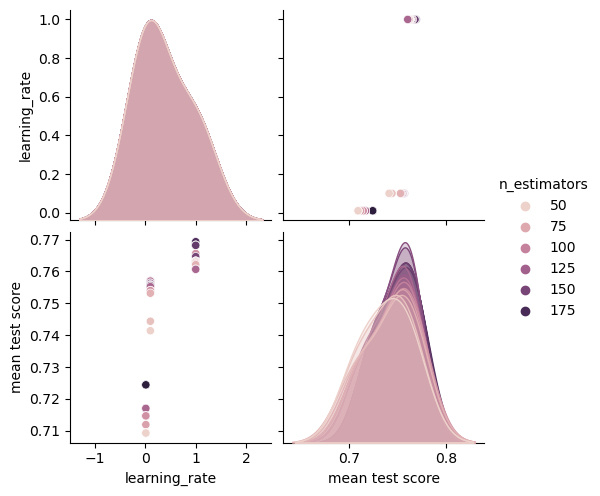

F1-Score en el conjunto de prueba: 0.7888563049853373
Tiempo de ejecución: 5.007934331893921 segundos


In [501]:
ada_boost = AdaBoostClassifier()

param_ada_boost = {
    'n_estimators': np.arange(50, 200, 10),
    'learning_rate': [0.01, 0.1, 1.0]
}

start_time = time.time()
df_ada_boost_summary = grid_search(X,y, ada_boost, param_ada_boost, hue_feat='n_estimators')
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

learning_rate: 1.000 
n_estimators: 90                         

Fitting 5 folds for each of 108 candidates, totalling 540 fits
  criterion max_depth  min_samples_leaf  min_samples_split  mean test score
0   entropy        50                 4                 10            0.752
1   entropy      None                 4                 10            0.752
2   entropy        30                 4                 10            0.752
3   entropy        40                 4                 10            0.752
4   entropy        20                 4                 10            0.752
Index(['criterion', 'max_depth', 'min_samples_leaf', 'min_samples_split',
       'mean test score'],
      dtype='object')


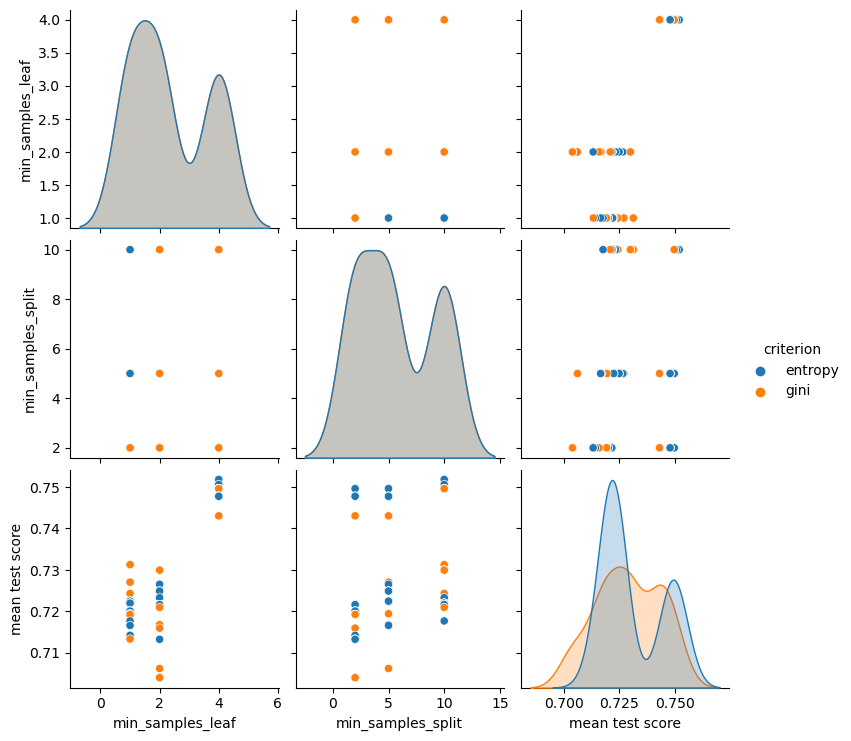

F1-Score en el conjunto de prueba: 0.8304821150855366
Tiempo de ejecución: 15.95148777961731 segundos


In [47]:
dt_model = DecisionTreeClassifier(random_state=42)


param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

start_time = time.time()
df_dt_summary = grid_search(X, y, dt_model, param_dt, hue_feat='criterion')
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

In [56]:

data = {
    'Model': ['KNN', 'LogisticRegression', 'GradientBoosting', 'RandomForest', 'SVM', 'AdaBoost', 'DecisionTree'],
    'Parameters': [
        'leaf_size: 27, n_neighbors: 7, weights: uniform',
        'l1_ratio: 0.500, penalty: l2',
        'learning_rate: 0.360, loss: deviance, max_depth: 1, n_estimators: 400',
        'criterion: gini, max_depth: 5, min_samples_leaf: 3, n_estimators: 150',
        'C: 1.000, gamma: scale, kernel: rbf',
        'learning_rate: 1.000, n_estimators: 170',
        'criterion: entropy, max_depth: 50, min_samples_leaf: 4, min_samples_split: 10'
    ],
    'Mean Score': [0.7938, 0.767, 0.775, 0.771, 0.770, 0.769, 0.752],
    'F1 ': [0.7819, 0.78195, 0.8023, 0.779, 0.7735, 0.78885, 0.83],
    'Time (sec)': [2.595, 1.7657, 187.7025,168.62861371040344, 2.6786, 5.0079, 15.95]
}

df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)

df

Model  \
0                 KNN   
1  LogisticRegression   
2    GradientBoosting   
3        RandomForest   
4                 SVM   
5            AdaBoost   
6        DecisionTree   

                                                                      Parameters  \
0                                leaf_size: 27, n_neighbors: 7, weights: uniform   
1                                                   l1_ratio: 0.500, penalty: l2   
2          learning_rate: 0.360, loss: deviance, max_depth: 1, n_estimators: 400   
3          criterion: gini, max_depth: 5, min_samples_leaf: 3, n_estimators: 150   
4                                            C: 1.000, gamma: scale, kernel: rbf   
5                                        learning_rate: 1.000, n_estimators: 170   
6  criterion: entropy, max_depth: 50, min_samples_leaf: 4, min_samples_split: 10   

   Mean Score   F1   Time (sec)  
0       0.794 0.782       2.595  
1       0.767 0.782       1.766  
2       0.775 0.802     187.702  
3       0.771 0.779     168.629  
4       0.770 0.773       2.679  
5       0.769 0.789       5.008  
6       0.752 0.830      15.950